# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator


from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

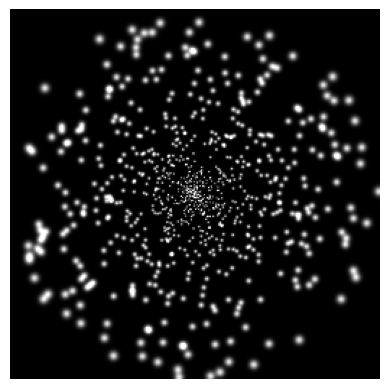

In [3]:
# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [4]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

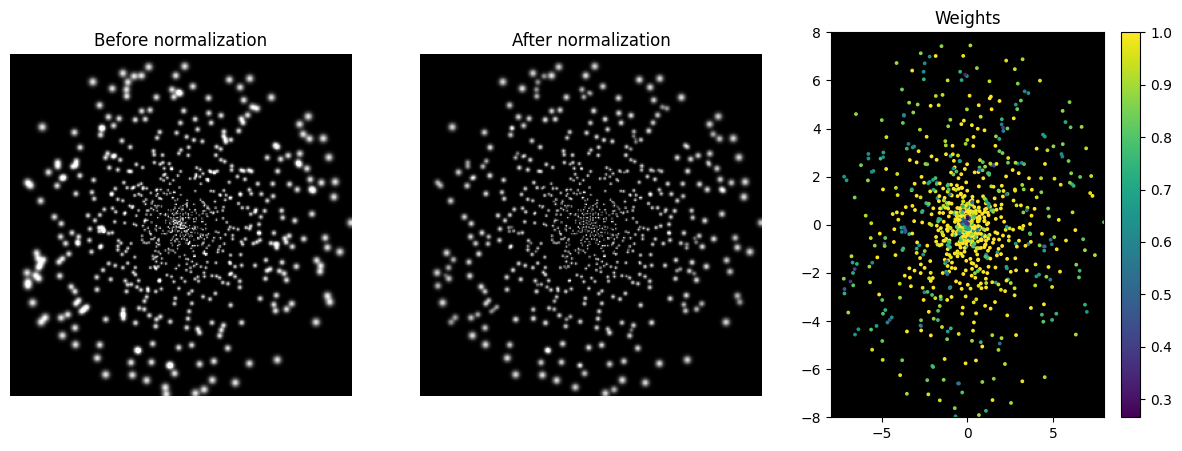

In [5]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=1,
    scale=0.5,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.05,
    steps=50,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init)
stim_weights = normalizer.weights

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# Phosphene Density Maps

In [6]:
from phosphene.density import VisualFieldMapper

In [7]:
mapper = VisualFieldMapper(simulator=simulator)

In [8]:
# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=32, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

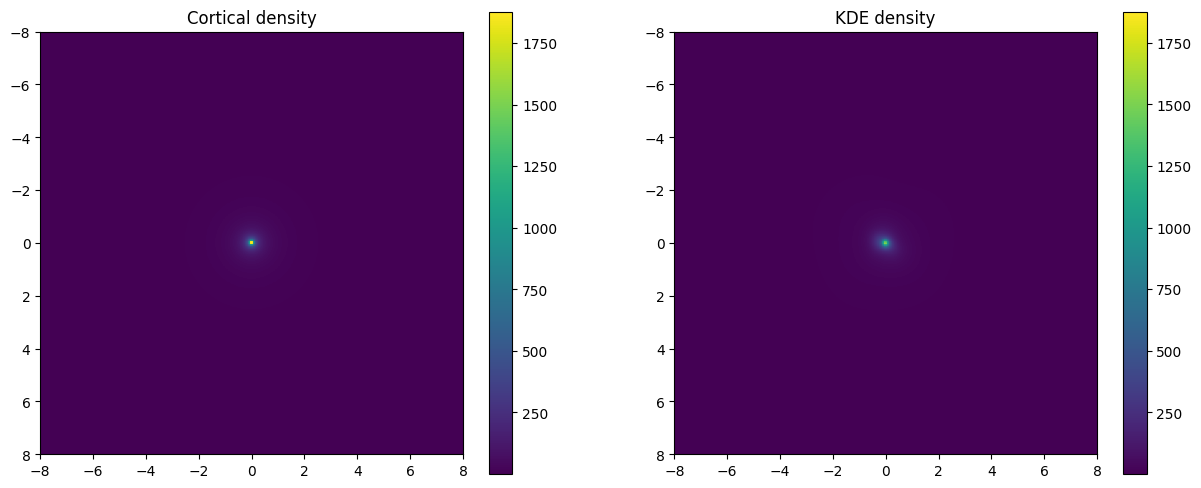

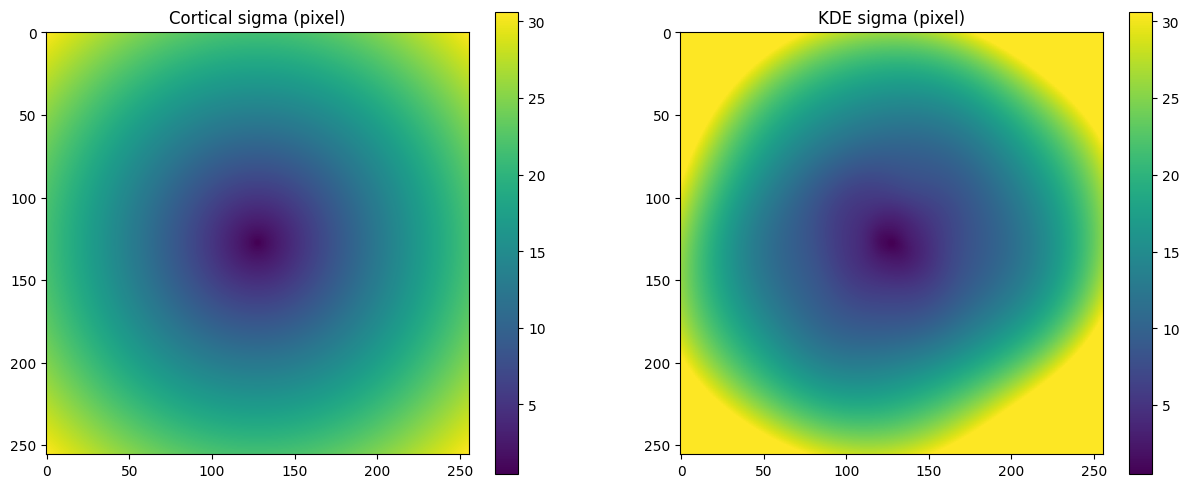

In [9]:
# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(density_cortical, cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2])
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(density_kde, cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=density_cortical.max())
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Adaptive Conv2D

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_loader = DataLoader(
    ImageFolder('../../data/LaPa_zoomed/', transform=transform),
    batch_size=1,
    shuffle=True
)

In [11]:
from components.adaptive_conv2d import AdaptiveConv2d

In [12]:
sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach() 

net = AdaptiveConv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=1,
    kernel_type="LoG",
    log_kernel_size=99,
    sigma_function="map",
    sigma_map=sigma_map_tensor,
    padding_mode="reflect"
).cuda()
net.eval()

/gpfs/home1/mappel/Dynaphos/spatial_frequency/notebooks/./../components/adaptive_conv2d.py:326: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_map = torch.tensor(sigma_map, dtype=torch.float32)


AdaptiveConv2d(
  (convolution): Conv2dWrapper(1, 1, kernel_size=(1, 1), stride=(1, 1), padding_mode=reflect)
)

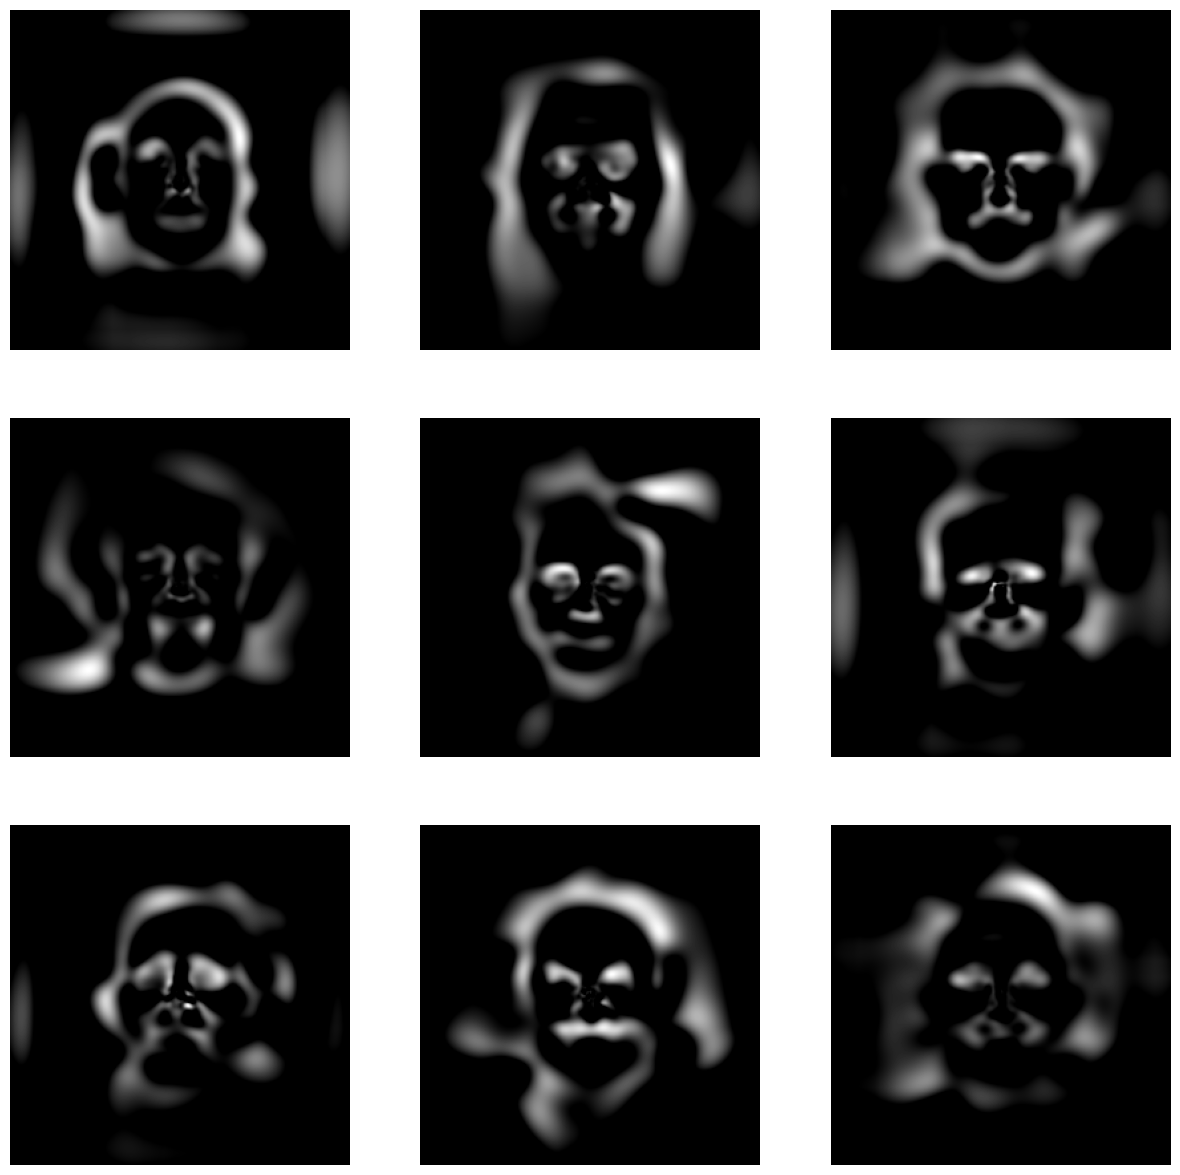

In [13]:
images = []
filtered_images = []

for img, _ in data_loader:
    img = img.cuda()
    # grayscale
    img = img.mean(dim=1, keepdim=True).detach()
    # center of the image
    foa_xy = torch.tensor([img.shape[3] // 2, img.shape[2] // 2]).float().cuda().unsqueeze(0).detach()
    with torch.no_grad():
        filtered_img = net(img, foa_xy).detach().cpu().clip(0, None).numpy()

    # normalize between 0 and 1
    filtered_img = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min())
    
    filtered_images.append(filtered_img)
    images.append(img.cpu())

    # show filtered_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(filtered_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0][0], cmap='gray')
    plt.axis('off')

plt.show()

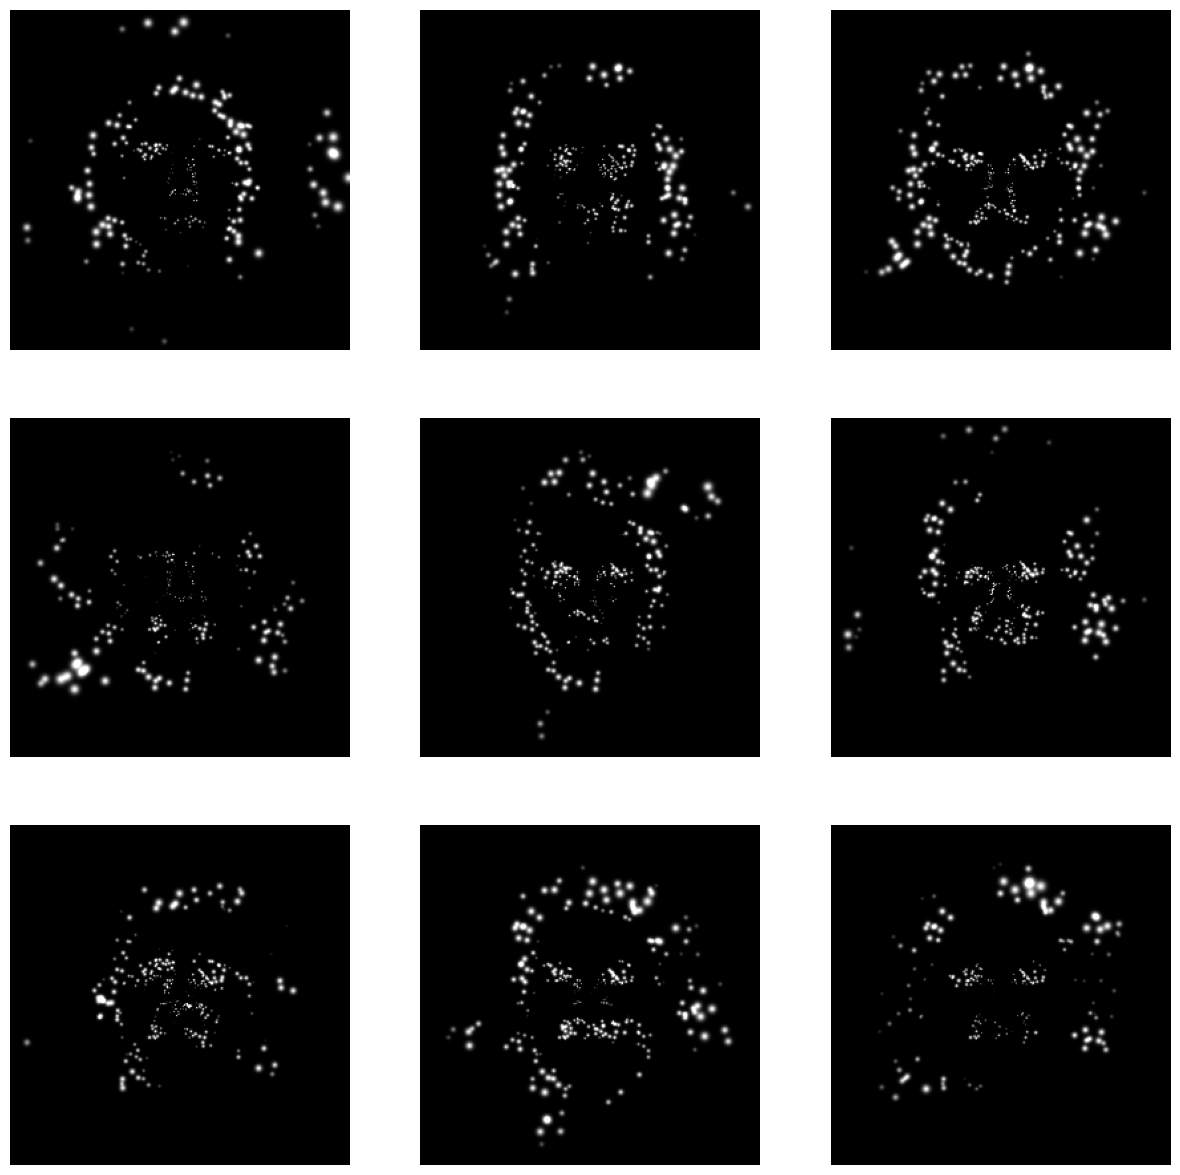

In [14]:
# show the images through the phosphene simulator

phos_images = []
for img in filtered_images:
    simulator.reset()
    stim = simulator.sample_stimulus(img[0][0], rescale=True) * stim_weights * np.pi
    phos_img = simulator(stim)
    phos_images.append(phos_img)

# show phos_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(phos_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img.cpu(), cmap='gray')
    plt.axis('off')

plt.show()

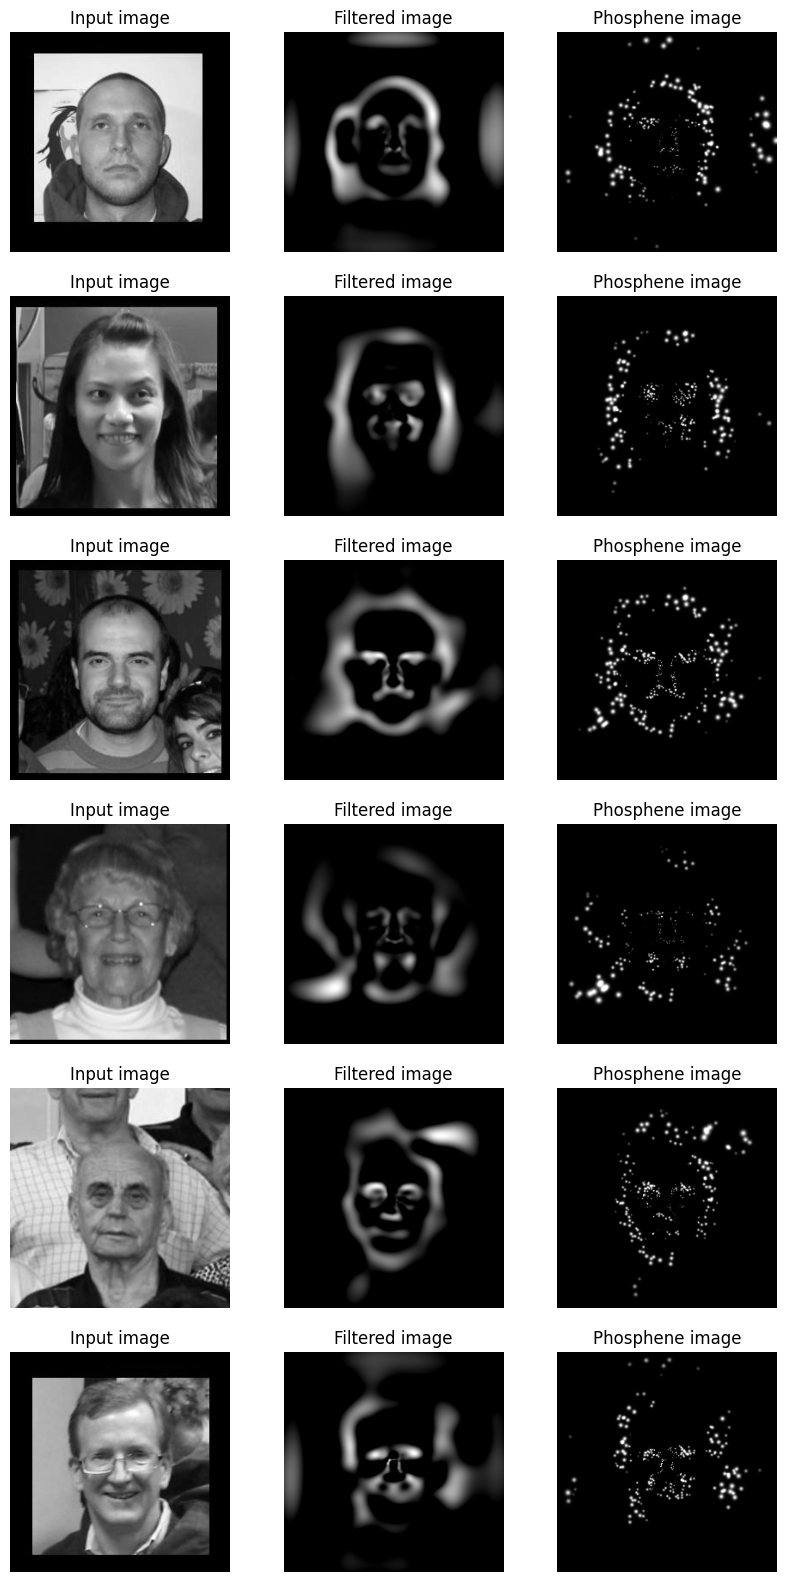

In [15]:
# show side by side:
# input image, filtered image and phosphene image

plt.figure(figsize=(10, 20))
imgs_to_show = 6

for i, (img, filtered_img, phos_img) in enumerate(zip(images, filtered_images, phos_images)):

    plt.subplot(imgs_to_show, 3, 3*i+1)
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Input image')

    plt.subplot(imgs_to_show, 3, 3*i+2)
    plt.imshow(filtered_img[0][0], cmap='gray')
    plt.axis('off')
    plt.title('Filtered image')

    plt.subplot(imgs_to_show, 3, 3*i+3)
    plt.imshow(phos_img.cpu(), cmap='gray')
    plt.axis('off')
    plt.title('Phosphene image')

    if i == imgs_to_show - 1:
        break

# Multi-Channel LoG

In [16]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_set = ImageFolder('../../data/LaPa_zoomed/', transform=transform)

In [17]:
from components.adaptive_conv2d import AdaptiveConv2d

In [18]:
sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach()

net = AdaptiveConv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=1,
    kernel_type="LoG",
    sigma_function="map",
    sigma_map=sigma_map_tensor,
    log_kernel_size=99,
    padding_mode="reflect"
).cuda()
net.eval()

AdaptiveConv2d(
  (convolution): Conv2dWrapper(1, 1, kernel_size=(1, 1), stride=(1, 1), padding_mode=reflect)
)

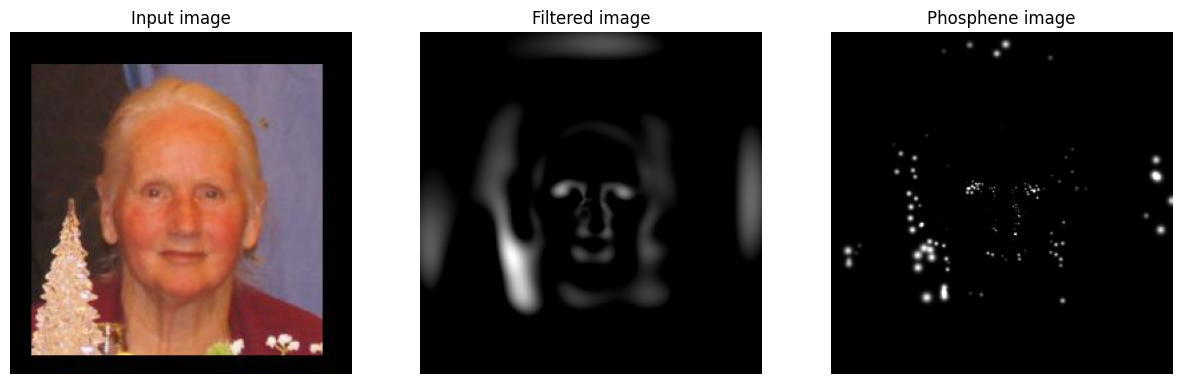

In [19]:
# get a specific index from the dataloader
index = 1
img_color = data_set.__getitem__(index)[0].unsqueeze(0)

# grayscale
img = img_color.mean(dim=1, keepdim=True)
img = img.cuda().detach()

# center of the image
foa_xy = torch.tensor([img.shape[2] // 2, img.shape[3] // 2]).float().cuda().unsqueeze(0).detach()

# filter the image
with torch.no_grad():
    filtered_img = net(img, foa_xy).clip(0, None)
# normailze the image between 0 and 1
filtered_img = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min())

simulator.reset()
stim = simulator.sample_stimulus(filtered_img[0][0].cuda(), rescale=True) * stim_weights * np.pi 
phos_img = simulator(stim)

# show the input image and filtered image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_color[0].cpu().permute(1, 2, 0))
plt.axis('off')
plt.title('Input image')

plt.subplot(1, 3, 2)
plt.imshow(filtered_img[0][0].squeeze().cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Filtered image')

plt.subplot(1, 3, 3)
plt.imshow(phos_img.detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Phosphene image')

plt.show()

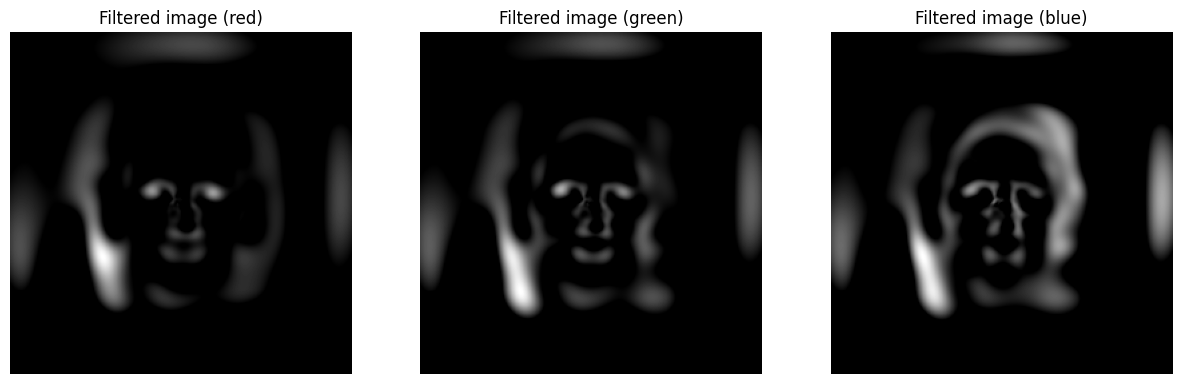

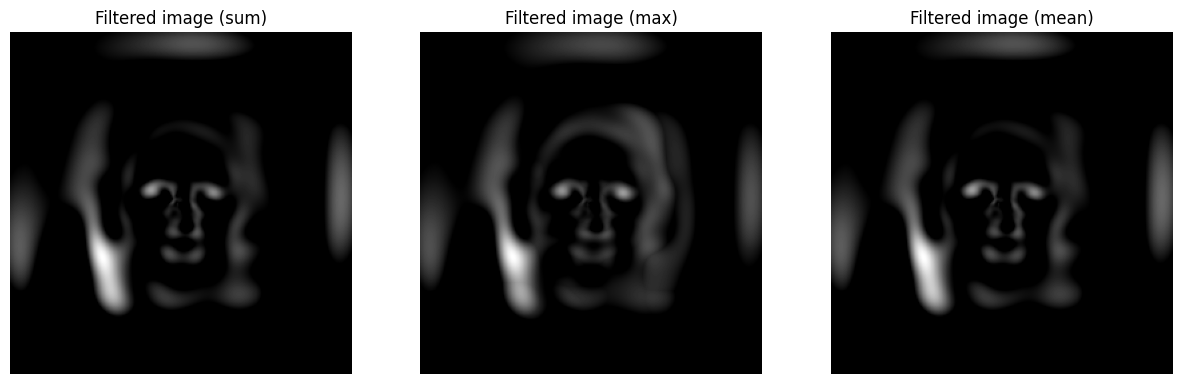

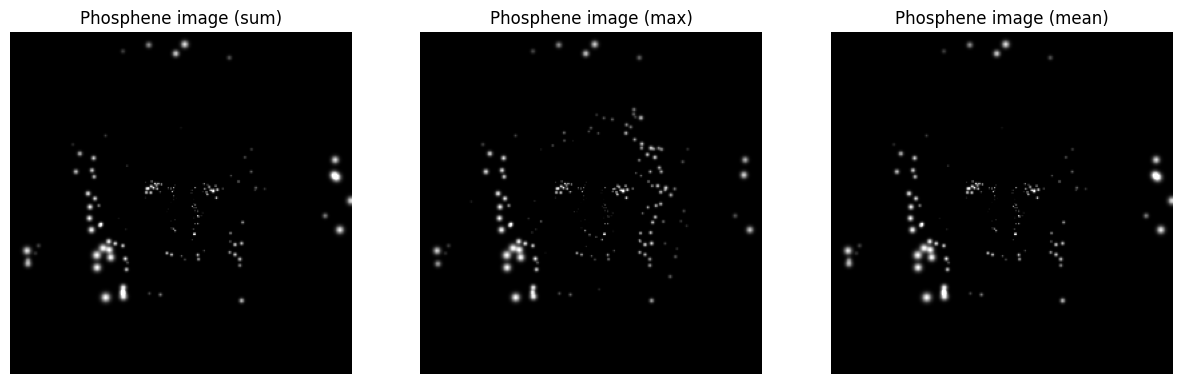

In [20]:
img_color = img_color.cuda()
img_r = img_color[:, 0, :, :].unsqueeze(1)
img_g = img_color[:, 1, :, :].unsqueeze(1)
img_b = img_color[:, 2, :, :].unsqueeze(1)

filtered_img_r = net(img_r, foa_xy)
filtered_img_g = net(img_g, foa_xy)
filtered_img_b = net(img_b, foa_xy)

filtered_img = torch.cat([filtered_img_r, filtered_img_g, filtered_img_b], dim=1)


# show
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(filtered_img_r[0][0].clip(0, None).squeeze().cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Filtered image (red)')
plt.subplot(1, 3, 2)
plt.imshow(filtered_img_g[0][0].clip(0, None).squeeze().cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Filtered image (green)')
plt.subplot(1, 3, 3)
plt.imshow(filtered_img_b[0][0].clip(0, None).squeeze().cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Filtered image (blue)')
plt.show()

# combine the filtered images using sum, max and mean
filtered_img_sum = filtered_img.sum(dim=1, keepdim=True).clip(0, None)
filtered_img_sum = (filtered_img_sum - filtered_img_sum.min()) / (filtered_img_sum.max() - filtered_img_sum.min())
filtered_img_max = filtered_img.max(dim=1, keepdim=True)[0].clip(0, None)
filtered_img_max = (filtered_img_max - filtered_img_max.min()) / (filtered_img_max.max() - filtered_img_max.min())
filtered_img_mean = filtered_img.mean(dim=1, keepdim=True).clip(0, None)
filtered_img_mean = (filtered_img_mean - filtered_img_mean.min()) / (filtered_img_mean.max() - filtered_img_mean.min())

# show
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(filtered_img_sum[0][0].squeeze().cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Filtered image (sum)')
plt.subplot(1, 3, 2)
plt.imshow(filtered_img_max[0][0].squeeze().cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Filtered image (max)')
plt.subplot(1, 3, 3)
plt.imshow(filtered_img_mean[0][0].squeeze().cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Filtered image (mean)')
plt.show()

# phosphene images for the combined filtered images
simulator.reset()
stim_sum = simulator.sample_stimulus(filtered_img_sum[0][0].cuda(), rescale=True) * stim_weights * np.pi
phos_img_sum = simulator(stim_sum).detach().cpu().numpy()

simulator.reset()
stim_max = simulator.sample_stimulus(filtered_img_max[0][0].cuda(), rescale=True) * stim_weights * np.pi
phos_img_max = simulator(stim_max).detach().cpu().numpy()

simulator.reset()
stim_mean = simulator.sample_stimulus(filtered_img_mean[0][0].cuda(), rescale=True) * stim_weights * np.pi
phos_img_mean = simulator(stim_mean).detach().cpu().numpy()

# show
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_img_sum, cmap='gray')
plt.axis('off')
plt.title('Phosphene image (sum)')
plt.subplot(1, 3, 2)
plt.imshow(phos_img_max, cmap='gray')
plt.axis('off')
plt.title('Phosphene image (max)')
plt.subplot(1, 3, 3)
plt.imshow(phos_img_mean, cmap='gray')
plt.axis('off')
plt.title('Phosphene image (mean)')
plt.show()
